In [10]:
import pandas as pd

# Load your data
data = pd.read_csv('SPY_2024-08.csv')

# Inspect the column names
print(data.columns)


Index(['timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Load and clean the dataset
data_cleaned = pd.read_csv('SPY_2024-08.csv')
data_cleaned['timestamp'] = pd.to_datetime(data_cleaned['timestamp'])
data_cleaned.set_index('timestamp', inplace=True)

# Shift the close price by one period to create the target variable close_t+1
data_cleaned['close_t+1'] = data_cleaned['close'].shift(-1)

# Drop rows with NaN values that result from the shift operation
data_cleaned.dropna(inplace=True)

# Define features (X) and target variable (y)
X = data_cleaned[['open', 'high', 'low', 'close']]  # Features for the current time period t
y = data_cleaned['close_t+1']  # Target is the close price for the next time period t+1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.5458306325311328
R-squared: 0.9956799615464341


Using Log Returns as a Feature

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load and clean the dataset
data_cleaned = pd.read_csv('SPY_2024-08.csv')
data_cleaned['timestamp'] = pd.to_datetime(data_cleaned['timestamp'])
data_cleaned.set_index('timestamp', inplace=True)

# Calculate log returns
data_cleaned['log_return'] = np.log(data_cleaned['close'] / data_cleaned['close'].shift(1))

# Shift the close price by one period to create the target variable close_t+1
data_cleaned['close_t+1'] = data_cleaned['close'].shift(-1)

# Drop rows with NaN values that result from the shift operation
data_cleaned.dropna(inplace=True)

# Define features (X) and target variable (y)
X = data_cleaned[['open', 'high', 'low', 'close', 'log_return']]  # Features for the current time period t, including log return
y = data_cleaned['close_t+1']  # Target is the close price for the next time period t+1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and train the Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.5450561288144322
R-squared: 0.9956860914439503


Base RFR Model Using Log Returns and Min-Max Scaled Volume as Input Feature

Hyper Parameter Tuning using Gridsearch

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Train RMSE: 0.005532498034705806, Test RMSE: 0.015008282527585888
Train MAE: 0.0008721749590827176, Test MAE: 0.004989997768803752
Train R2: 0.9994320039351259, Test R2: 0.9956950271426472


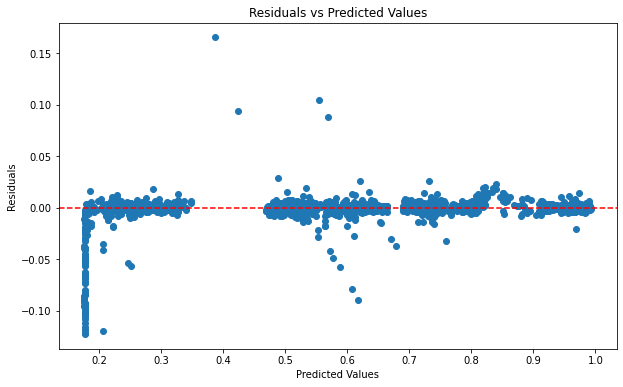

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the dataset
# Replace 'your_data.csv' with the path to your dataset
data = pd.read_csv('SPY_2024-08.csv')

# Ensure the date column is datetime format if present
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(by='date')

# Drop any non-numeric columns except the target
data = data.select_dtypes(include=[np.number])

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Feature Engineering: Lag Features
for lag in range(1, 6):  # Creating lag features up to lag 5
    scaled_data[f'close_lag_{lag}'] = scaled_data['close'].shift(lag)

# Feature Engineering: Rolling Window Features
scaled_data['rolling_mean'] = scaled_data['close'].rolling(window=5).mean()
scaled_data['rolling_std'] = scaled_data['close'].rolling(window=5).std()

# Drop any rows with NaN values that were created by shifting or rolling
scaled_data.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = scaled_data.drop(columns=['close'])  # Assuming 'close' is the target
y = scaled_data['close']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the model
rfr = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Use the best model
best_rfr = grid_search.best_estimator_

# Predictions
y_train_pred = best_rfr.predict(X_train)
y_test_pred = best_rfr.predict(X_test)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train RMSE: {train_rmse}, Test RMSE: {test_rmse}')
print(f'Train MAE: {train_mae}, Test MAE: {test_mae}')
print(f'Train R2: {train_r2}, Test R2: {test_r2}')

# Residual Analysis
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


In [ ]:
# pip install tqdm

        Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²   Test R²
0  Base Model    0.074082   0.722908   0.014611   0.22965  0.999958  0.995864


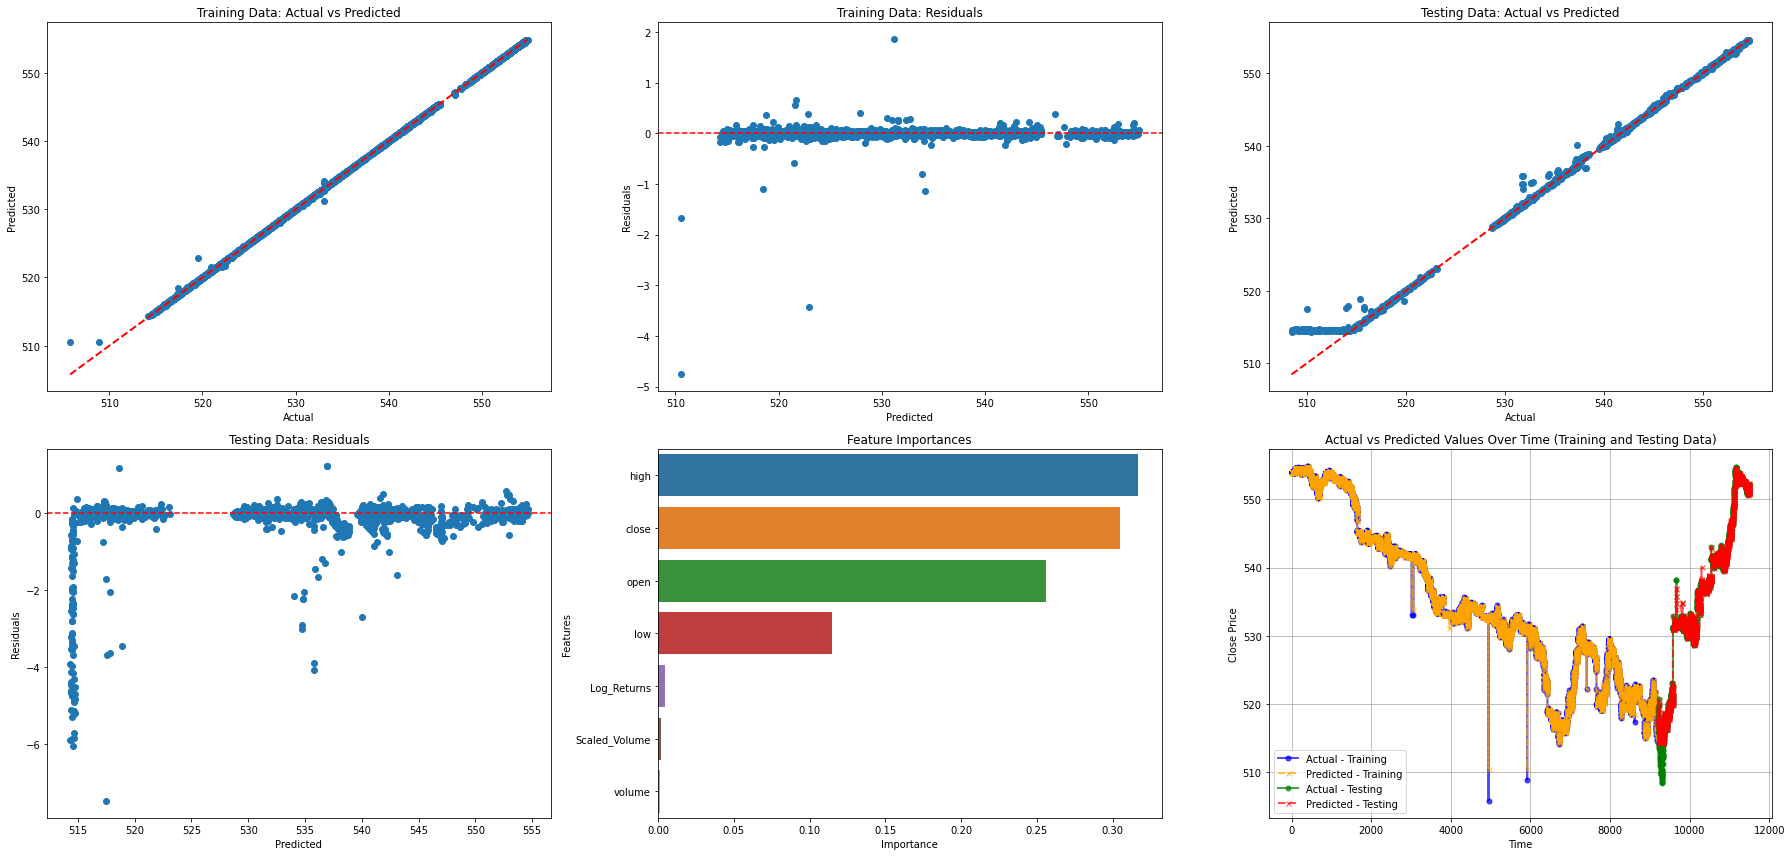

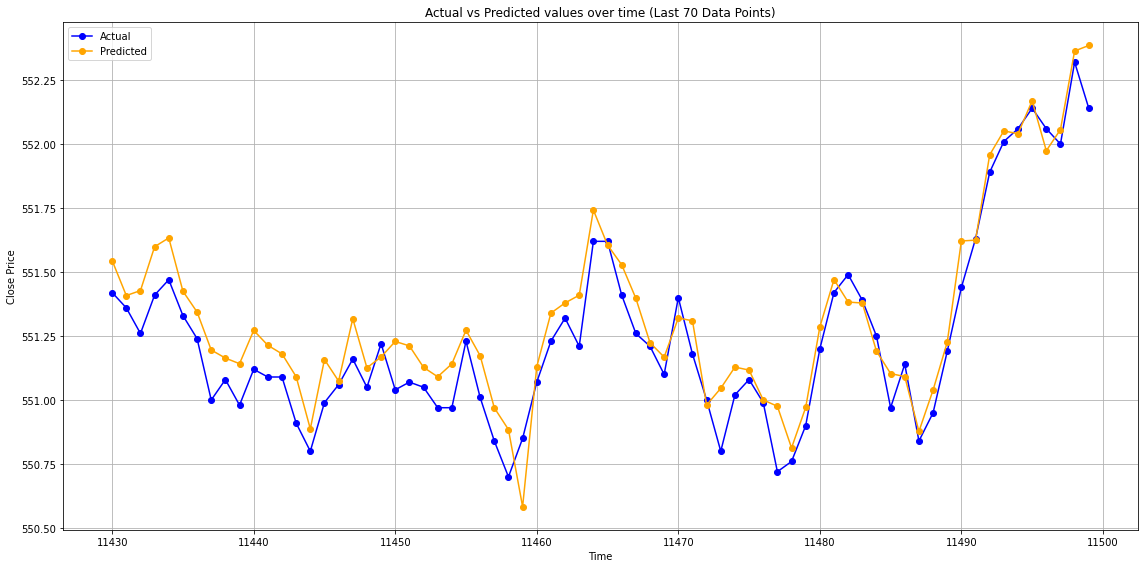

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Drop NaN values resulting from the shift operation
data = data.dropna()

# Define the features (including standard features and the engineered ones)
X = data[['open', 'high', 'low', 'close', 'volume', 'Log_Returns', 'Scaled_Volume']]
y = data['close']  # Assuming 'close' is the target variable for prediction

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Initialize a dictionary to store the results for later analysis
results = {
    'Model': ['Base Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('base_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results
plt.figure(figsize=(25, 12))

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


--------------------------------------------------------------------------------TECHNICAL INDICATORS START HERE--------------------------------------------------------------------------------

SMA 10 period

          Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  \
0  SMA_10 Model    0.162001   0.785181   0.026549  0.241126  0.999798   

    Test R²  
0  0.995114  


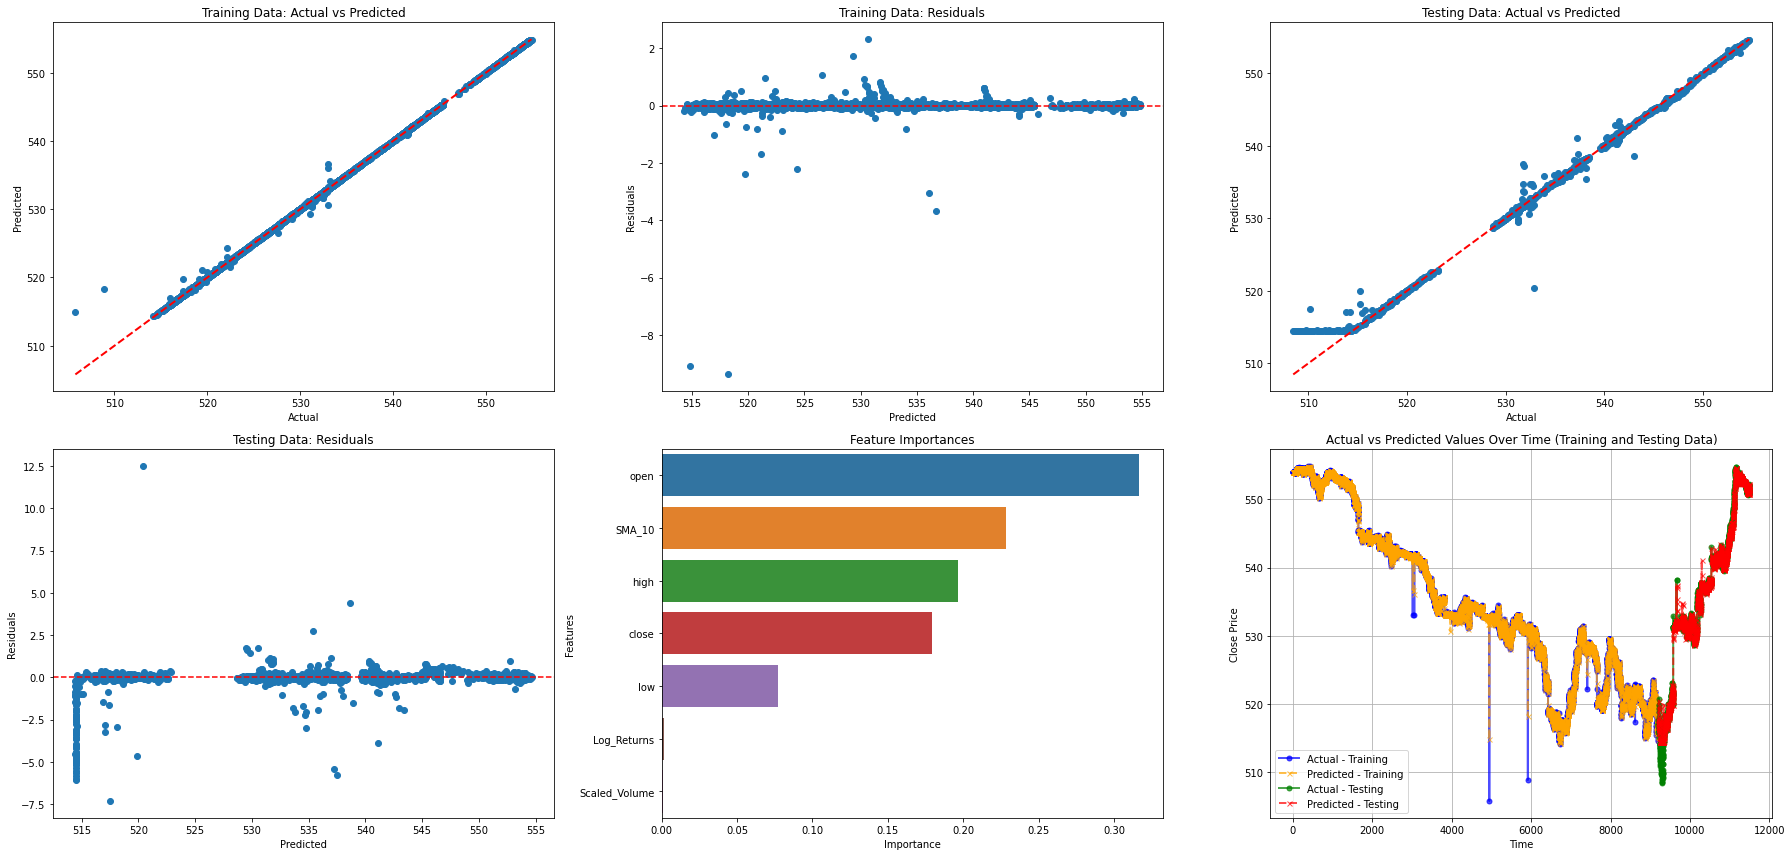

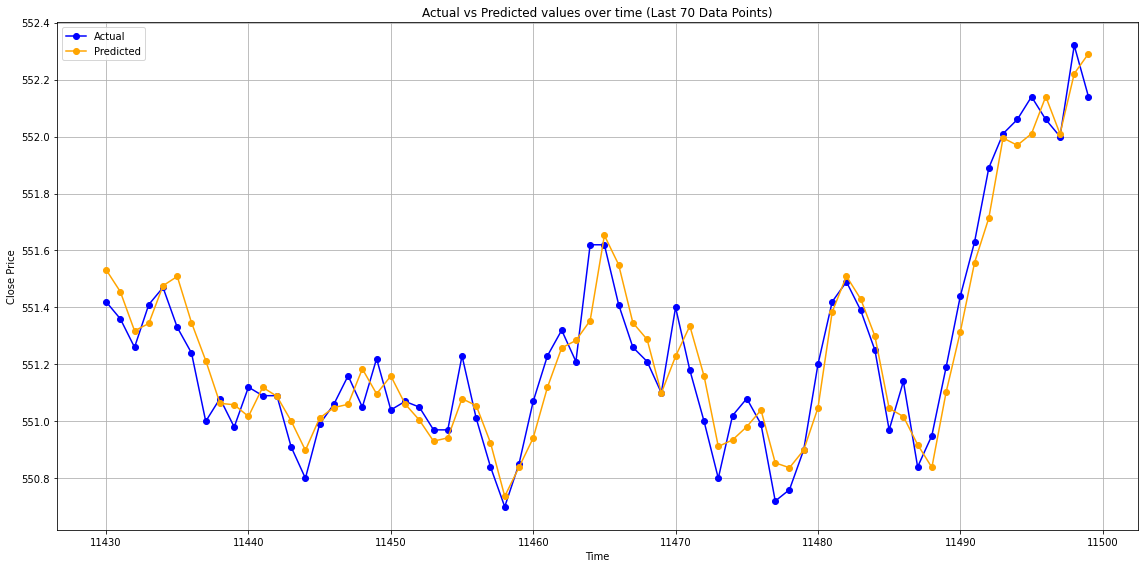

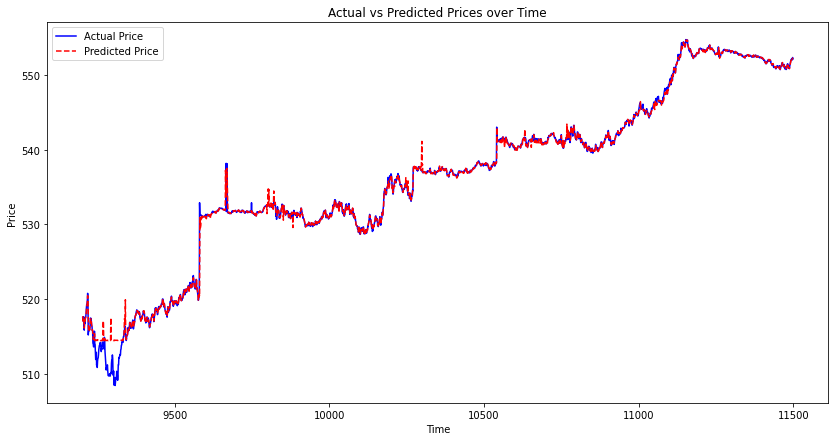

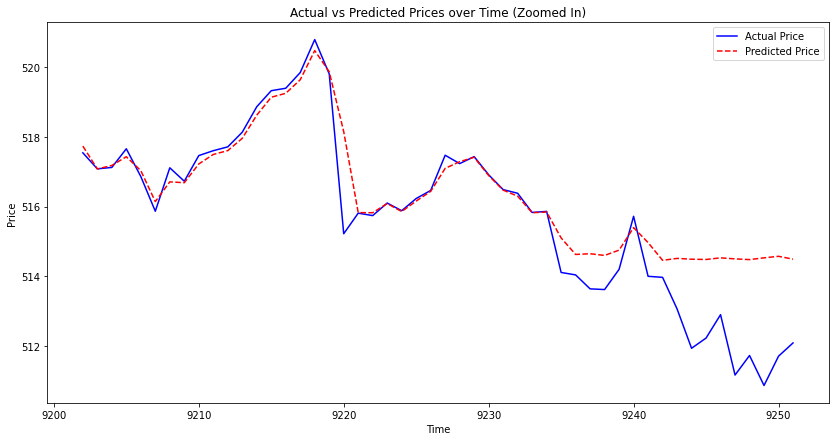

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Add Simple Moving Average (SMA_10)
data['SMA_10'] = data['close'].rolling(window=10).mean()

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', 'SMA_10']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Initialize a dictionary to store the results for later analysis
results = {
    'Model': ['SMA_10 Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('sma10_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results
plt.figure(figsize=(25, 12))

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


RSI

       Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²   Test R²
0  RSI Model    0.152496   0.873943   0.027349  0.280735  0.999821  0.993955


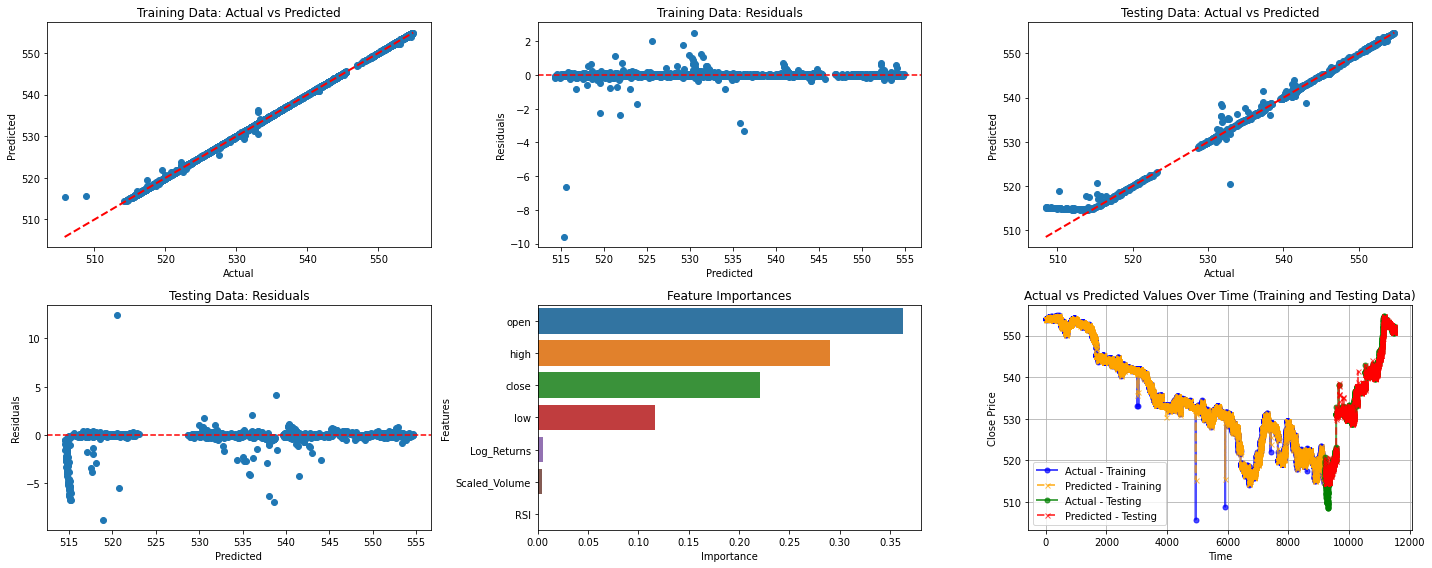

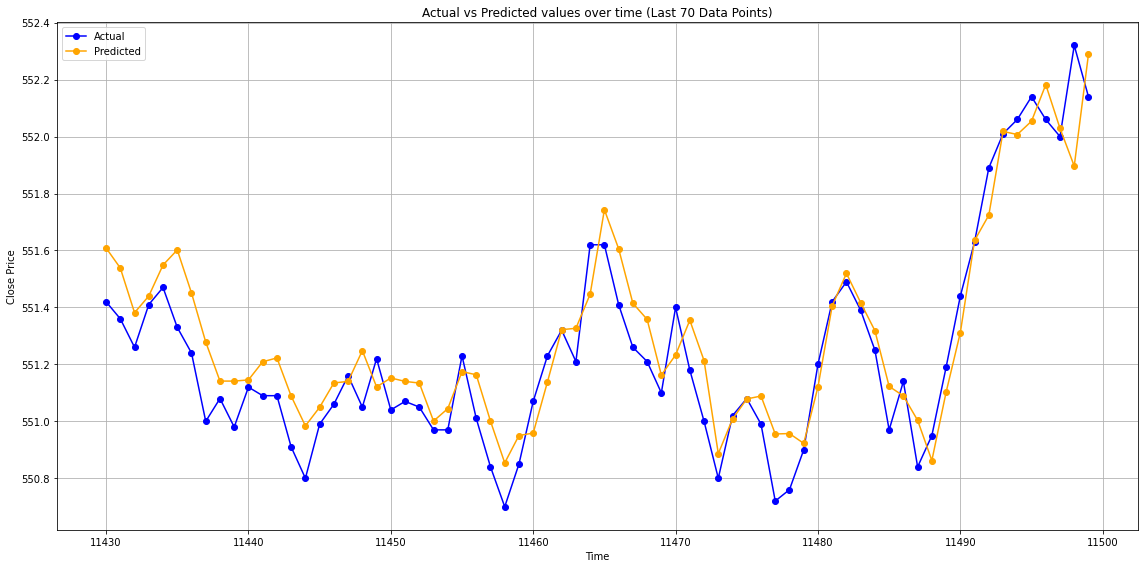

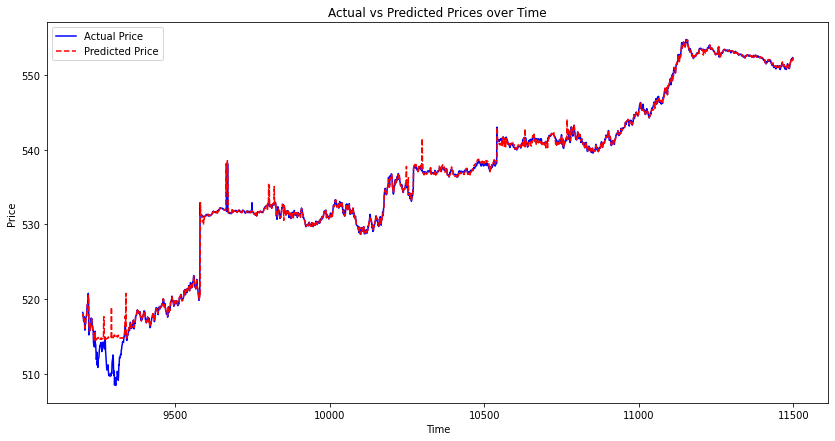

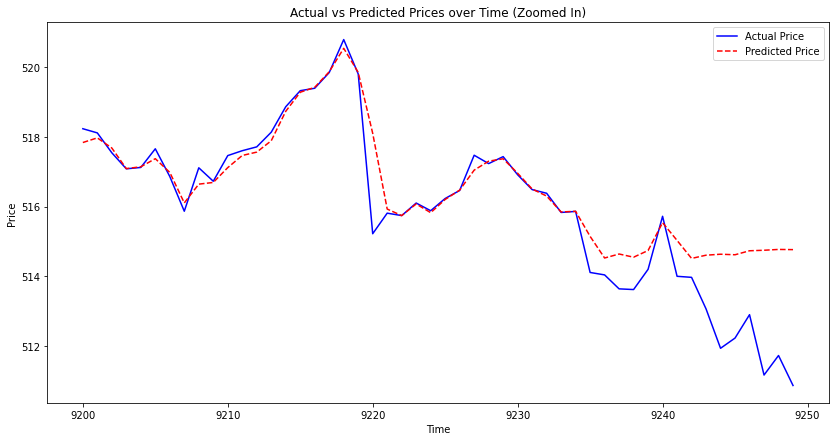

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Calculate RSI
window_length = 14

# Calculate daily price changes
delta = data['close'].diff()

# Make the positive gains (up) and negative gains (down) Series
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate the average gain and loss
avg_gain = gain.rolling(window=window_length, min_periods=1).mean()
avg_loss = loss.rolling(window=window_length, min_periods=1).mean()

# Calculate RS (Relative Strength)
rs = avg_gain / avg_loss

# Calculate RSI
data['RSI'] = 100 - (100 / (1 + rs))

# Drop NaN values resulting from the calculation
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', 'RSI']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Initialize a dictionary to store the results for later analysis
results = {
    'Model': ['RSI Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('rsi_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


EMA 10 Period

          Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²
0  EMA_10 Model    0.150315   0.797963   0.026084  0.244848  0.999826  0.99496


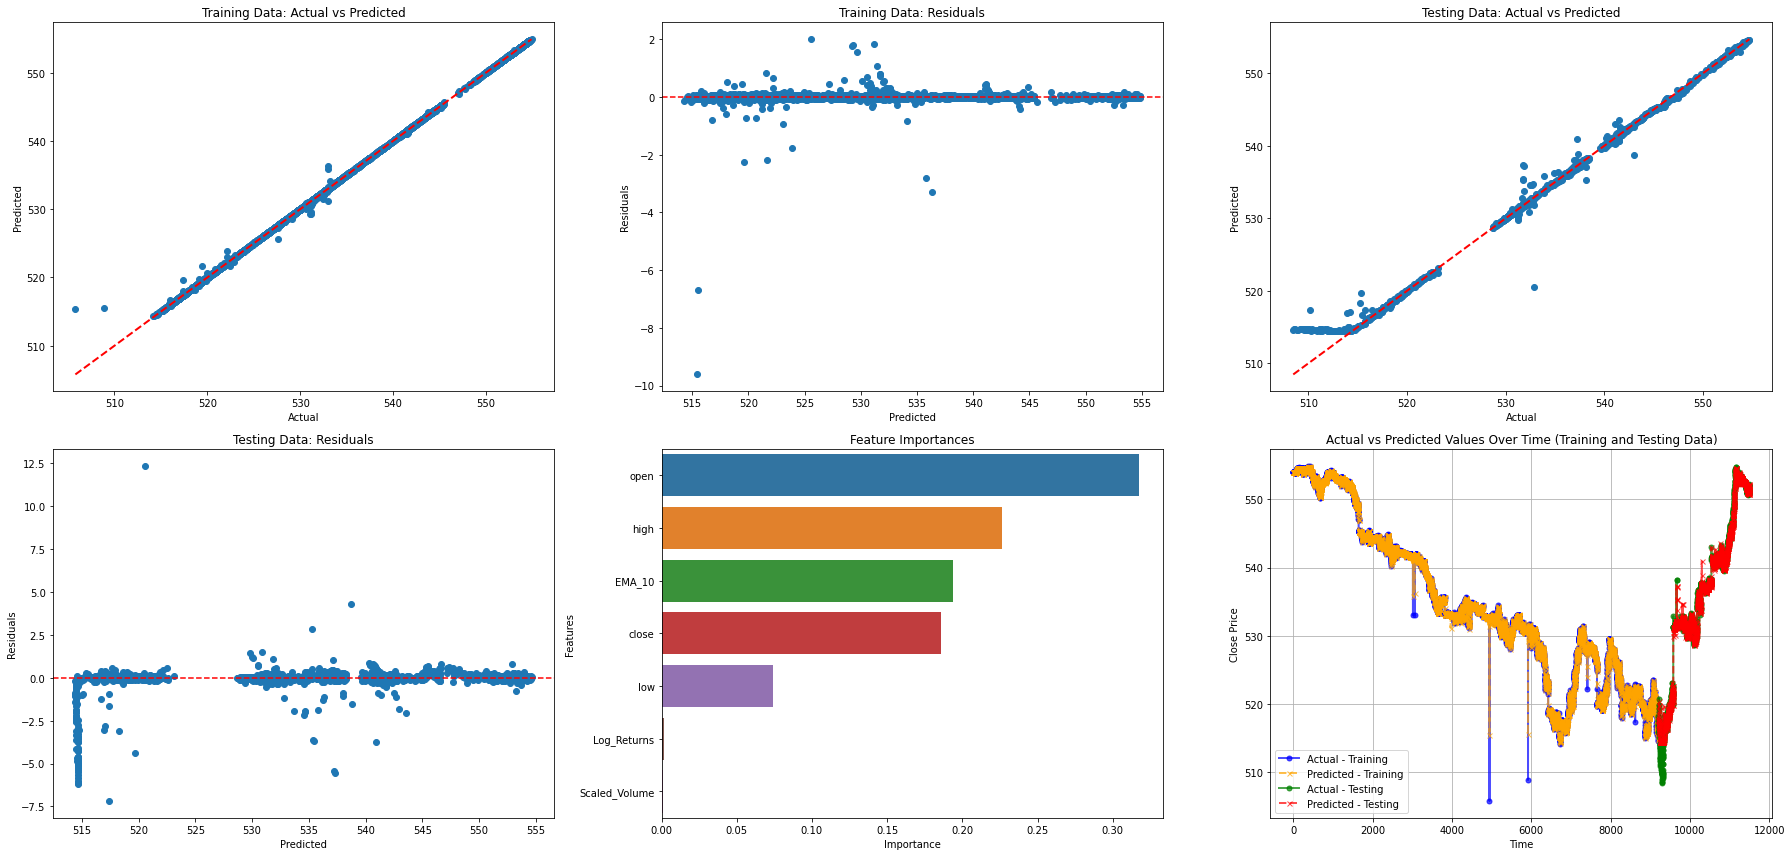

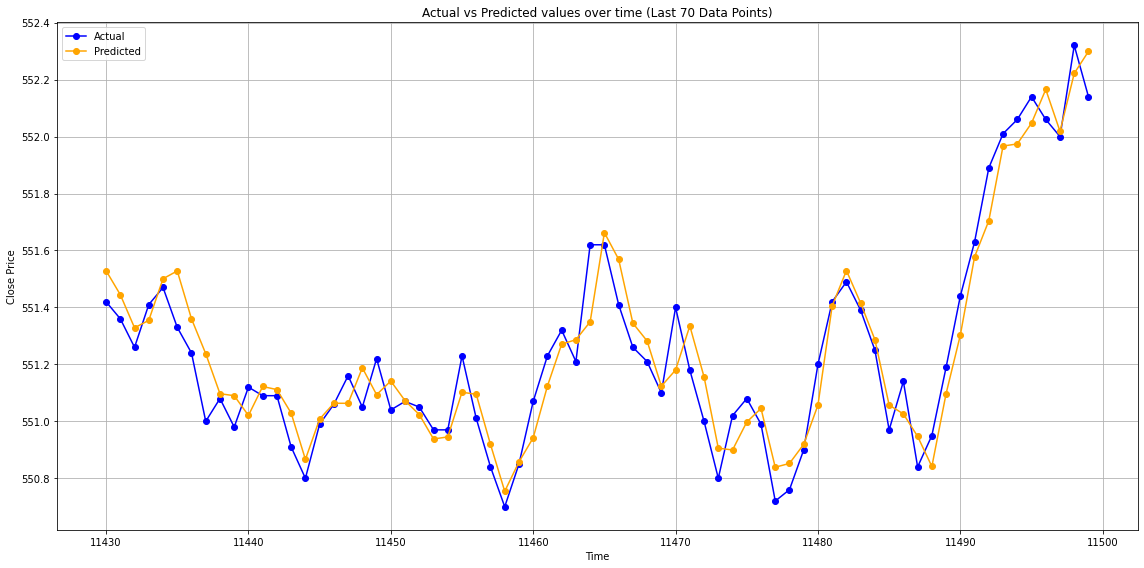

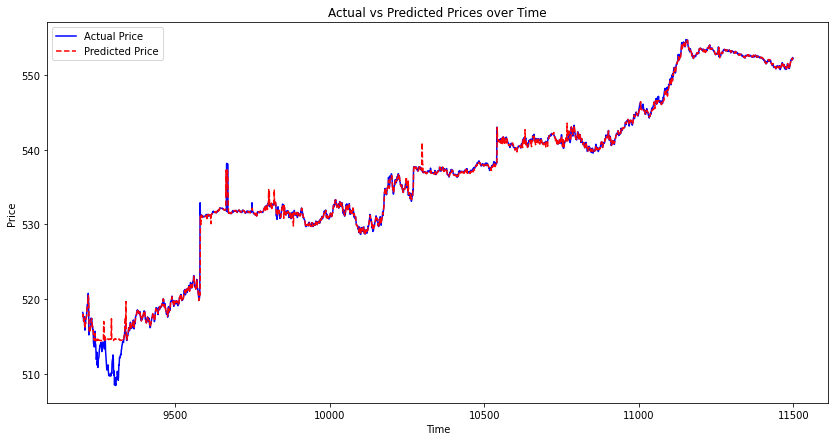

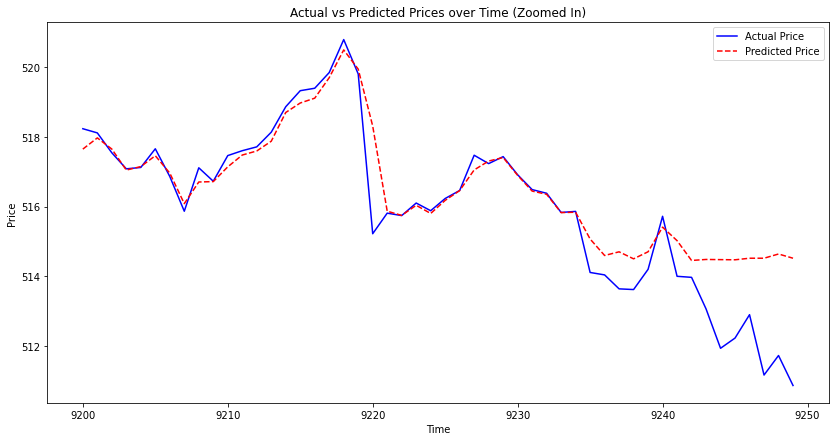

In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Add Exponential Moving Average (EMA_10)
data['EMA_10'] = data['close'].ewm(span=10, adjust=False).mean()

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', 'EMA_10']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Initialize a dictionary to store the results for later analysis
results = {
    'Model': ['EMA_10 Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('ema10_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results
plt.figure(figsize=(25, 12))

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


MACD

        Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²   Test R²
0  MACD Model    0.155328   0.890577   0.026677  0.276686  0.999815  0.993723


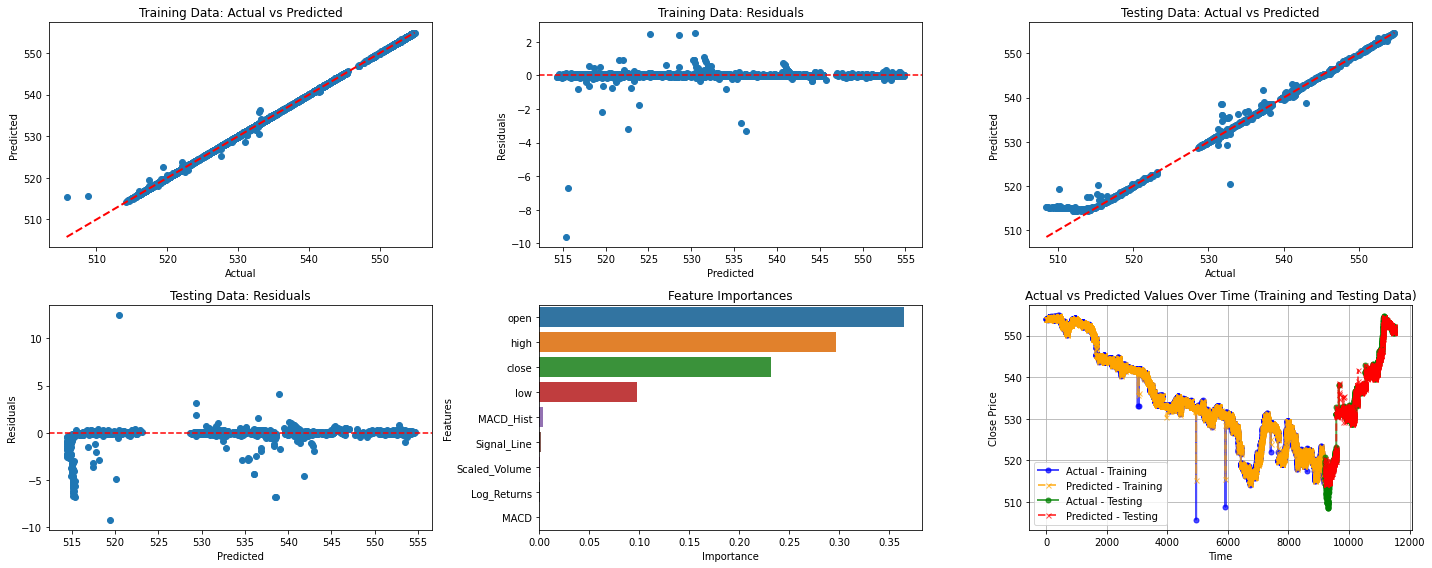

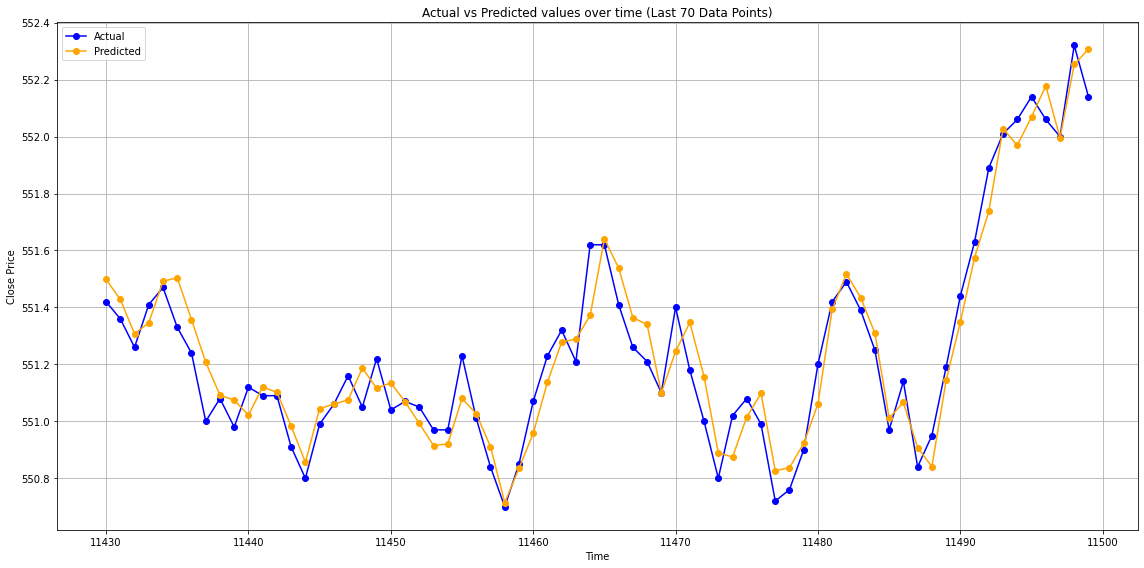

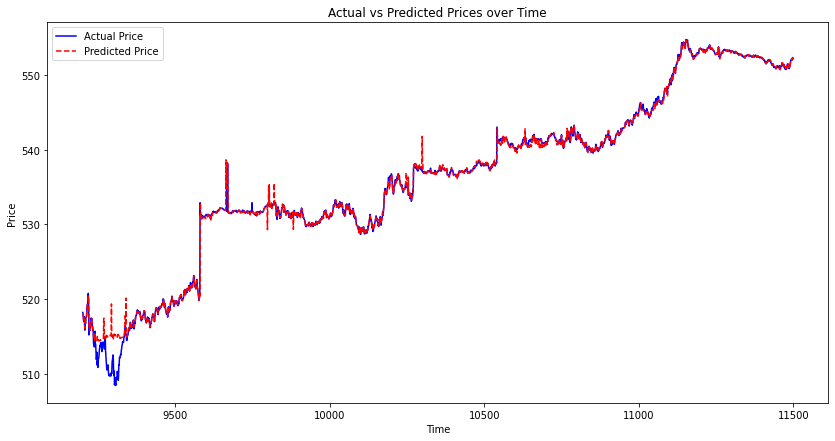

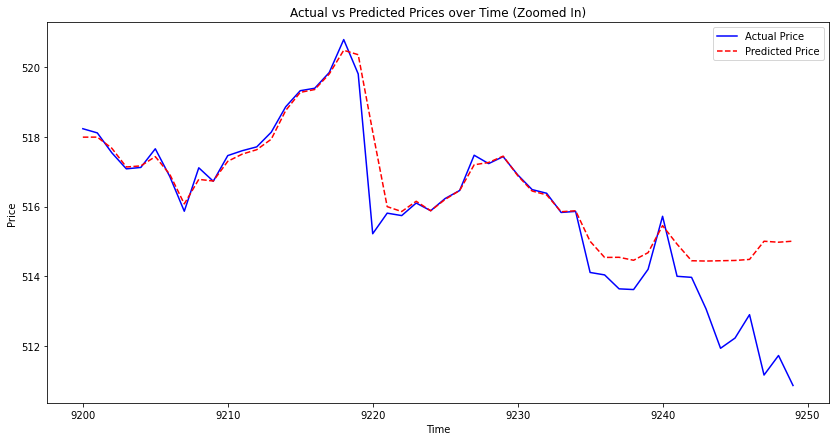

In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Calculate MACD and Signal Line
data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Hist'] = data['MACD'] - data['Signal_Line']

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', 'MACD', 'Signal_Line', 'MACD_Hist']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Initialize a dictionary to store the results for later analysis
results = {
    'Model': ['MACD Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('macd_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


Bollinger Bands

                   Model  Train RMSE  Test RMSE  Train MAE  Test MAE  \
0  Bollinger Bands Model    0.174002     0.8157   0.026191  0.260626   

   Train R²   Test R²  
0  0.999767  0.994718  


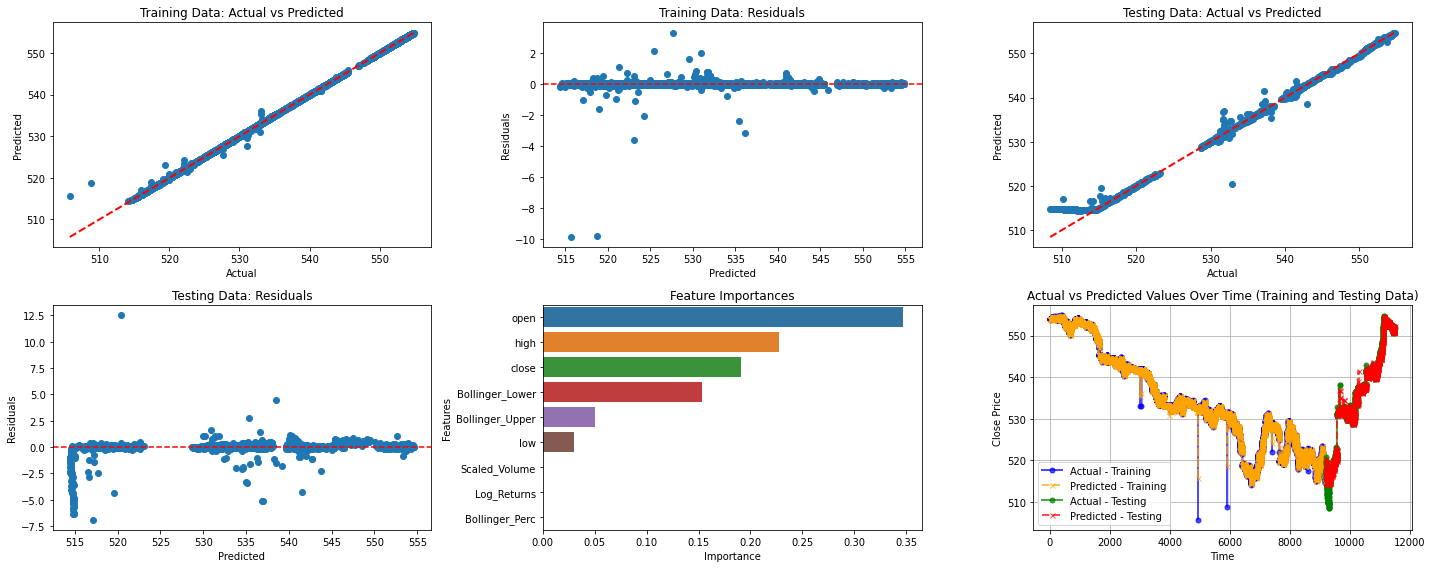

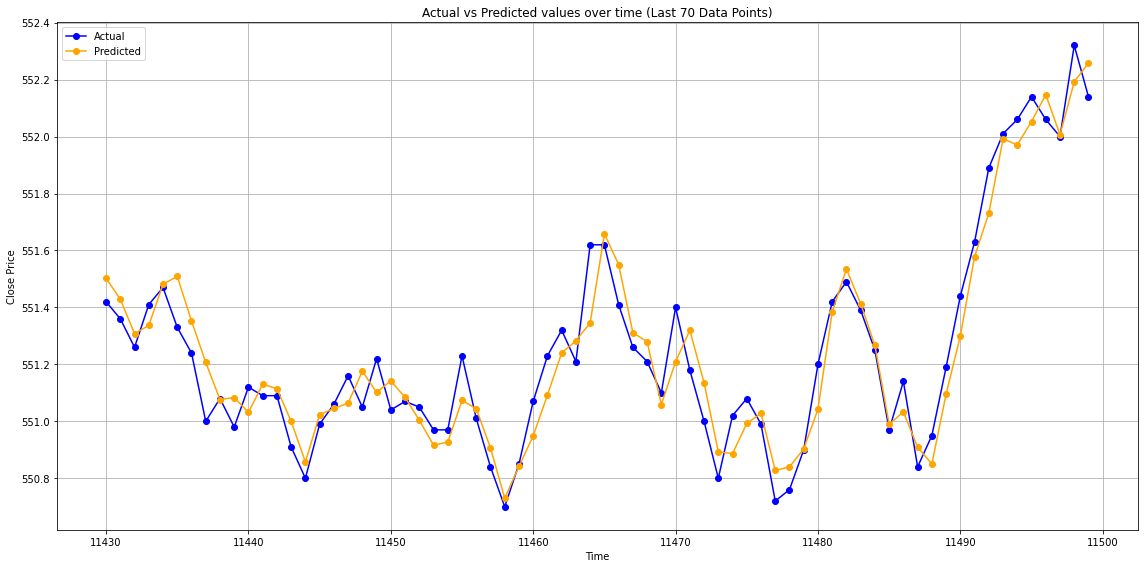

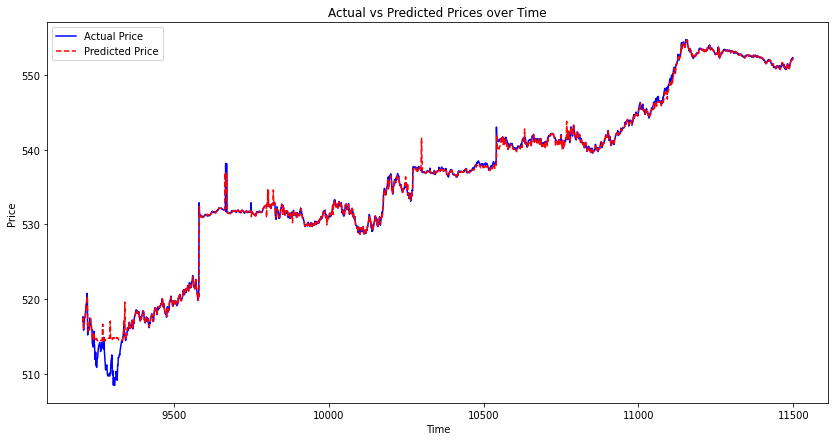

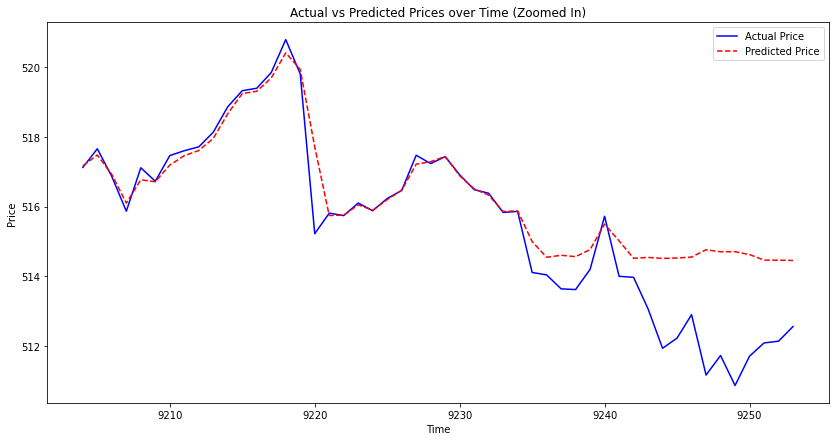

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Calculate Bollinger Bands
data['SMA_20'] = data['close'].rolling(window=20).mean()
data['STD_20'] = data['close'].rolling(window=20).std()
data['Bollinger_Upper'] = data['SMA_20'] + (data['STD_20'] * 2)
data['Bollinger_Lower'] = data['SMA_20'] - (data['STD_20'] * 2)

# Optional: Distance from Bollinger Bands
data['Bollinger_Perc'] = (data['close'] - data['Bollinger_Lower']) / (data['Bollinger_Upper'] - data['Bollinger_Lower'])

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', 'Bollinger_Upper', 'Bollinger_Lower', 'Bollinger_Perc']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Initialize a dictionary to store the results for later analysis
results = {
    'Model': ['Bollinger Bands Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('bollinger_bands_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


Stochastic Oscillator

                         Model  Train RMSE  Test RMSE  Train MAE  Test MAE  \
0  Stochastic Oscillator Model       0.176   0.930228   0.030638  0.303642   

   Train R²   Test R²  
0  0.999761  0.993137  


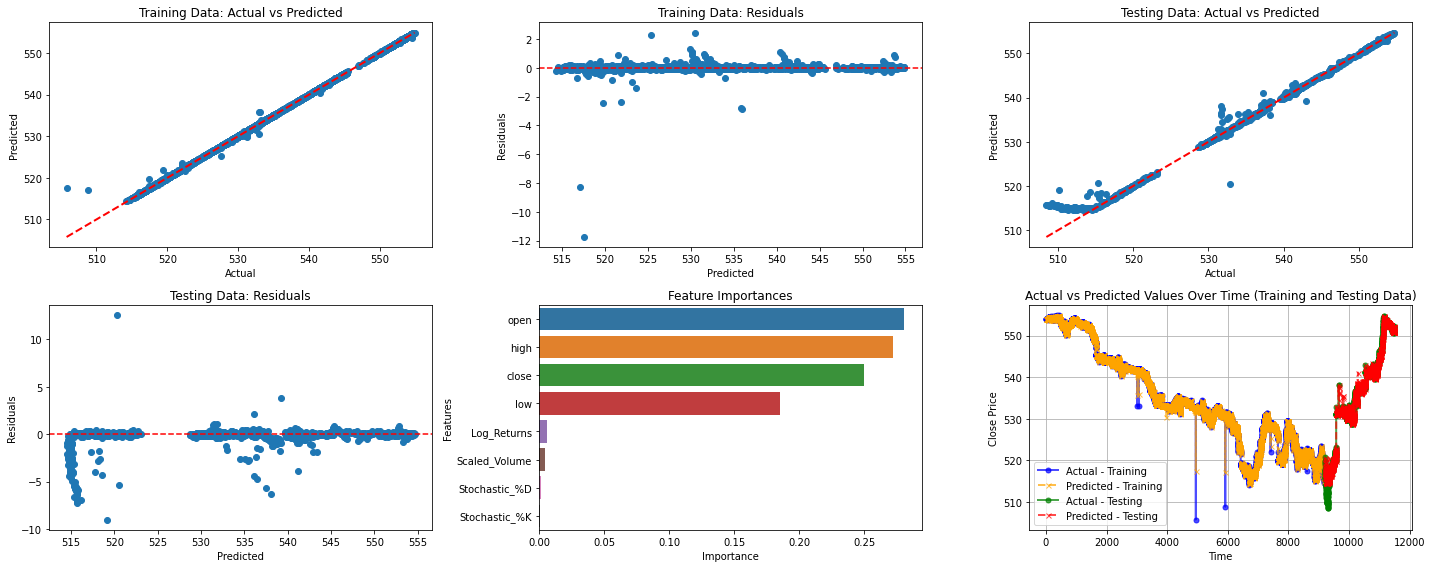

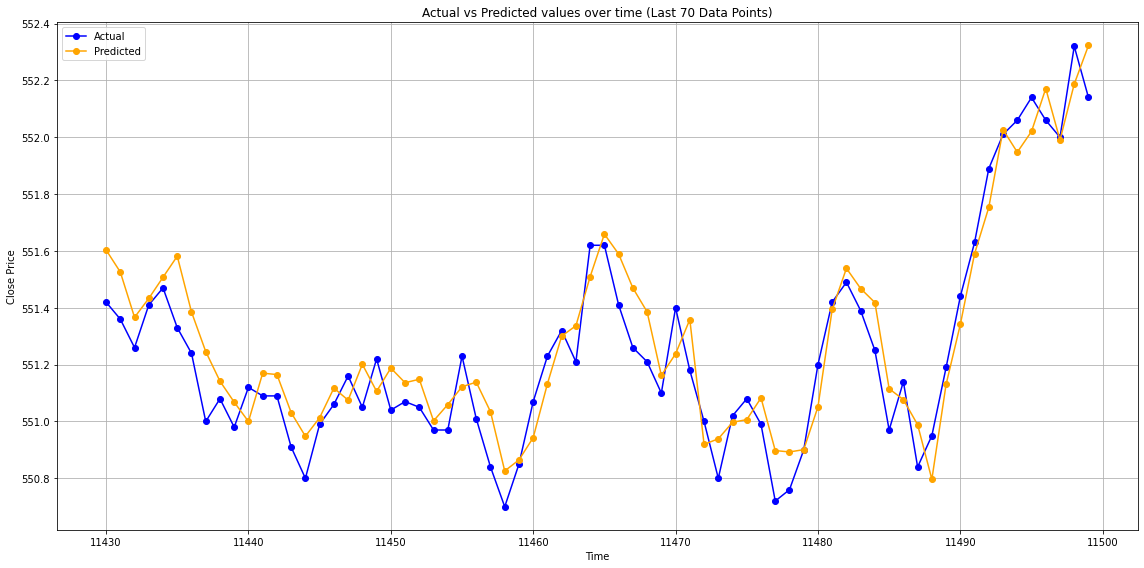

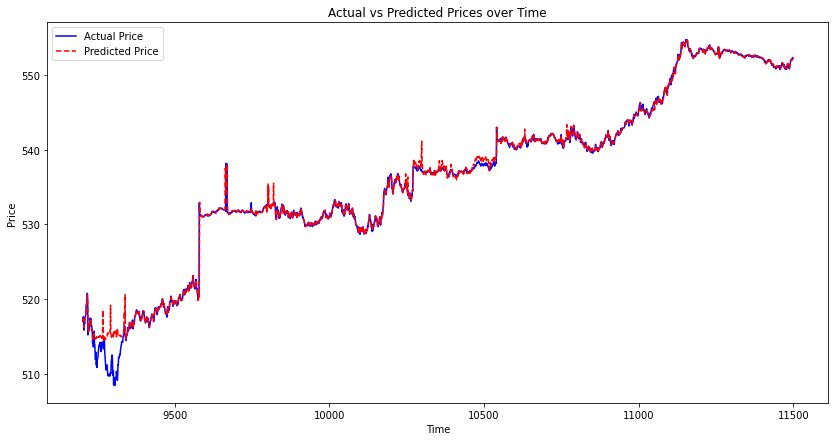

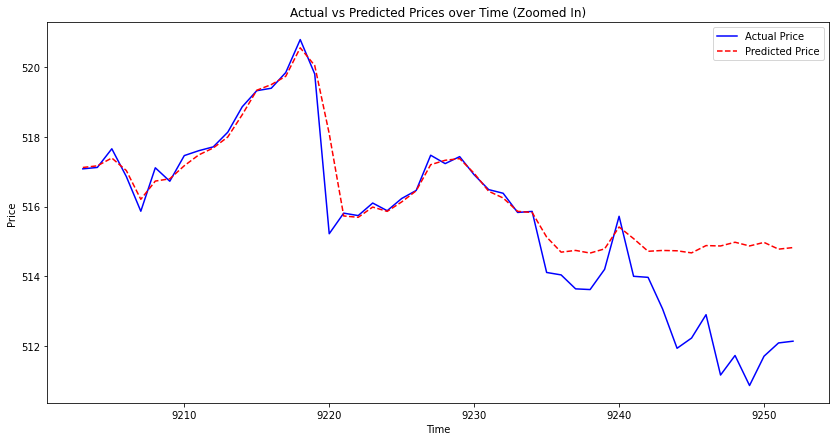

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Calculate Stochastic Oscillator
data['Lowest_Low_14'] = data['low'].rolling(window=14).min()
data['Highest_High_14'] = data['high'].rolling(window=14).max()
data['Stochastic_%K'] = 100 * ((data['close'] - data['Lowest_Low_14']) / (data['Highest_High_14'] - data['Lowest_Low_14']))
data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()

# Drop NaN values resulting from shift and rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', 'Stochastic_%K', 'Stochastic_%D']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Initialize a dictionary to store the results for later analysis
results = {
    'Model': ['Stochastic Oscillator Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('stochastic_oscillator_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


Fibbonnacci Retracement

                         Model  Train RMSE  Test RMSE  Train MAE  Test MAE  \
0  Fibonacci Retracement Model    0.175257   1.107321   0.028494  0.351699   

   Train R²   Test R²  
0  0.999763  0.990267  


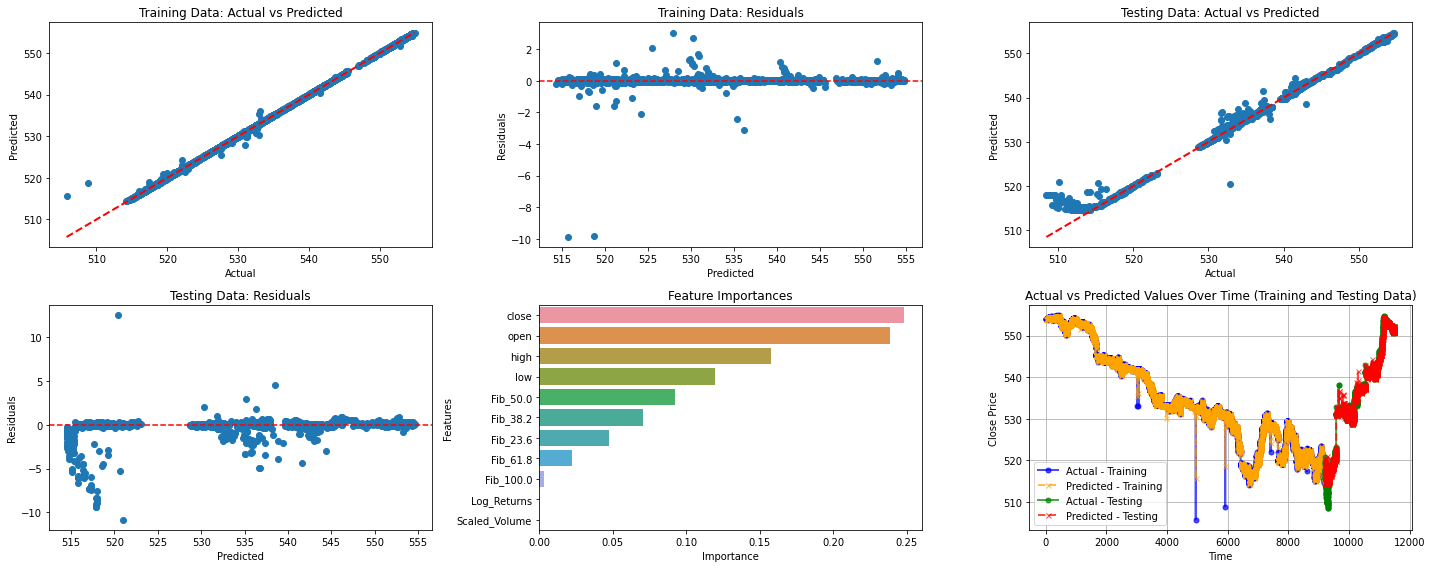

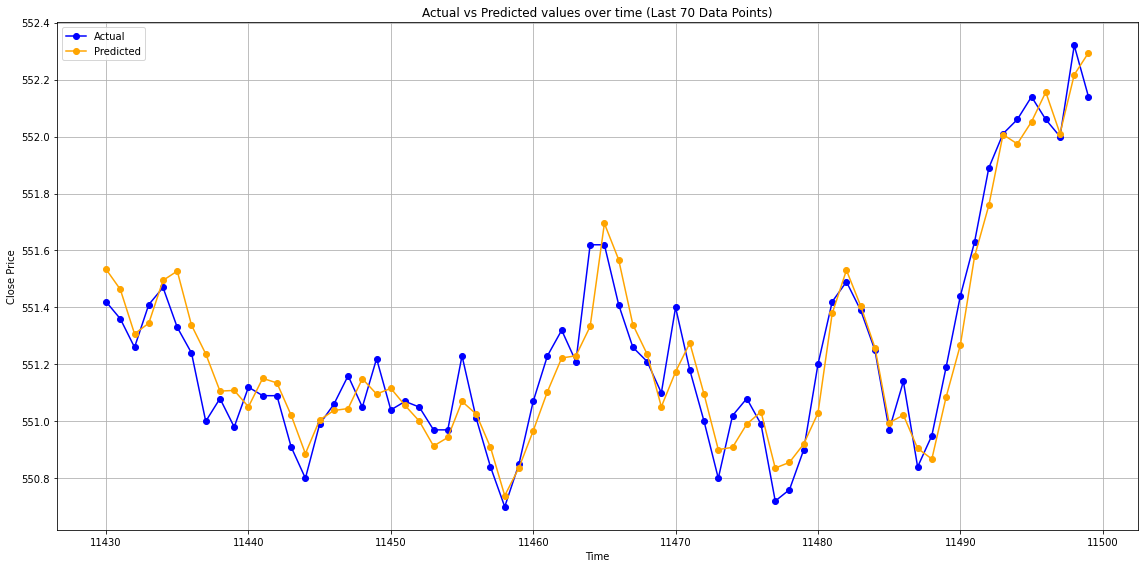

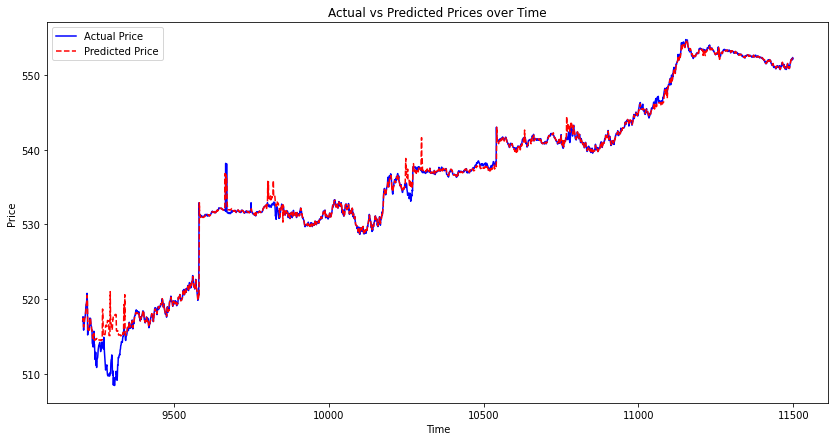

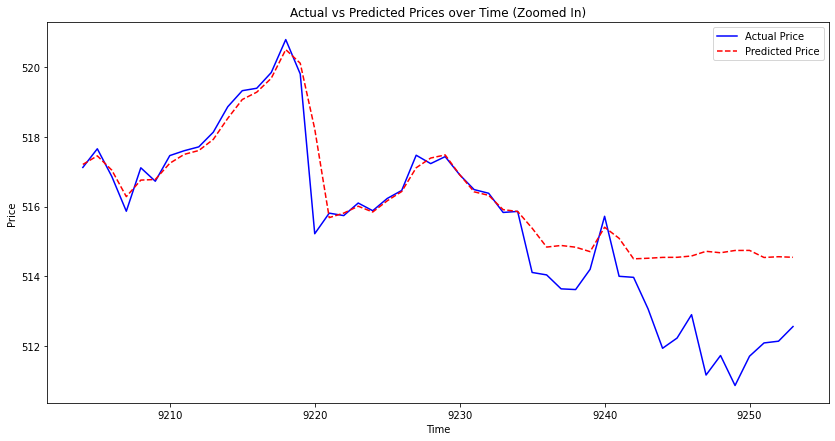

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Calculate Fibonacci Retracement Levels
lookback_period = 20  # You can adjust this period based on your needs

data['Swing_High'] = data['high'].rolling(window=lookback_period).max()
data['Swing_Low'] = data['low'].rolling(window=lookback_period).min()

# Fibonacci levels
data['Fib_23.6'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.236
data['Fib_38.2'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.382
data['Fib_50.0'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.5
data['Fib_61.8'] = data['Swing_High'] - (data['Swing_High'] - data['Swing_Low']) * 0.618
data['Fib_100.0'] = data['Swing_Low']  # This is the same as Swing_Low

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume',
          'Fib_23.6', 'Fib_38.2', 'Fib_50.0', 'Fib_61.8', 'Fib_100.0']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and save metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and save metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Initialize a dictionary to store the results for later analysis
results = {
    'Model': ['Fibonacci Retracement Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

# Convert the dictionary to a DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('fibonacci_retracement_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


ADX

       Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  Test R²
0  ADX Model     0.15633   0.904876   0.025719  0.280629  0.999812  0.99352


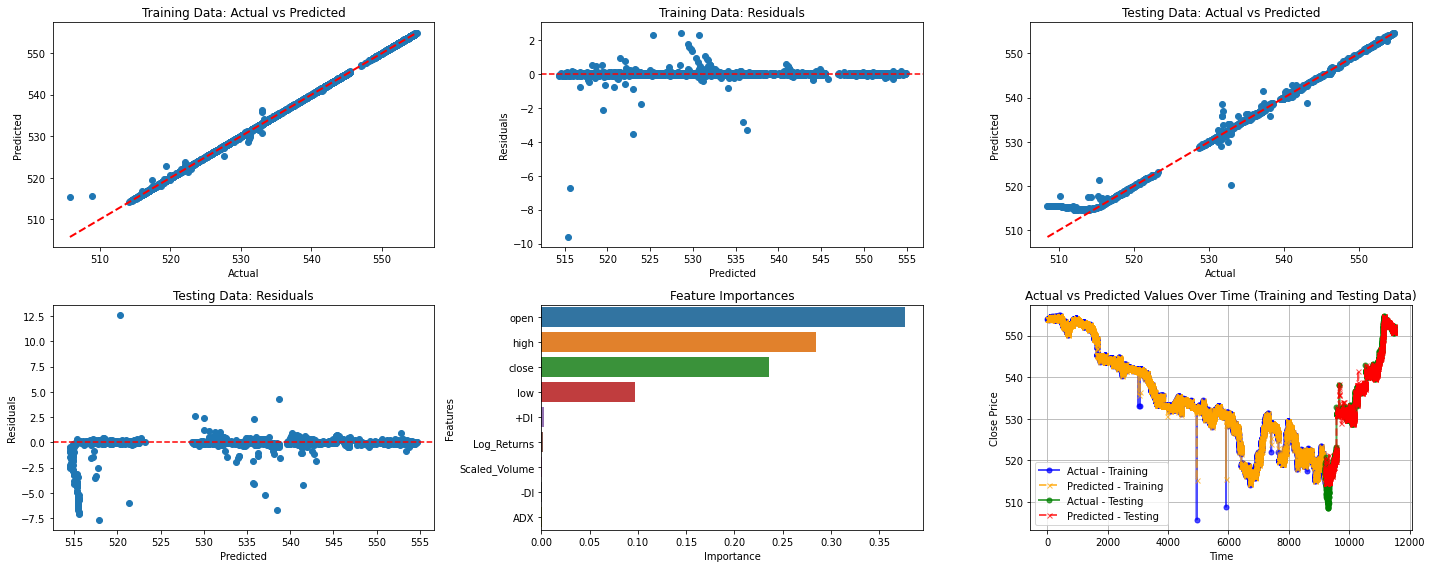

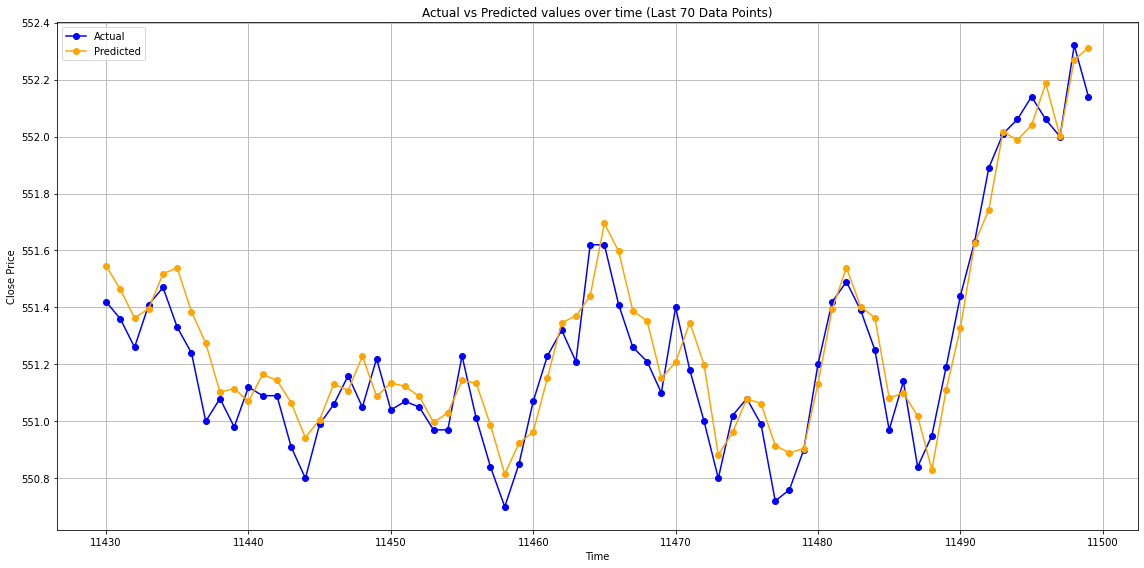

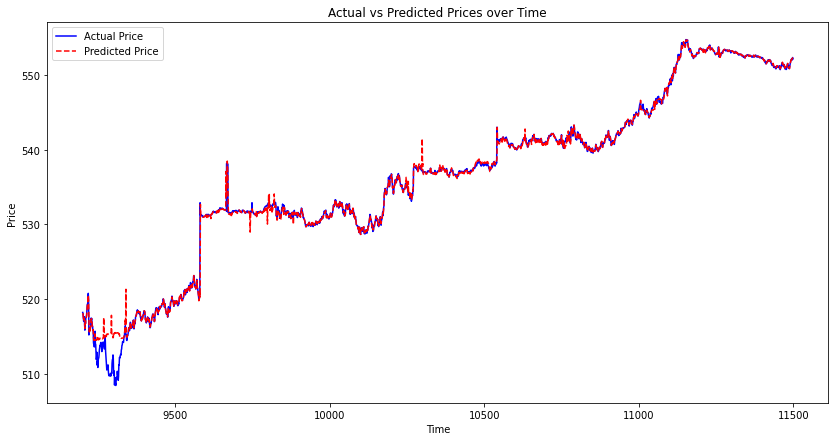

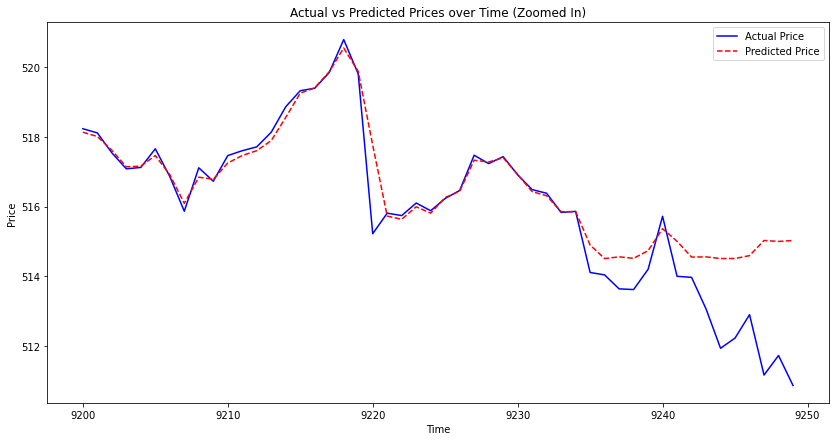

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Calculate the True Range (TR)
data['High-Low'] = data['high'] - data['low']
data['High-Close'] = np.abs(data['high'] - data['close'].shift(1))
data['Low-Close'] = np.abs(data['low'] - data['close'].shift(1))
data['TR'] = data[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)

# Calculate the +DI and -DI
data['+DM'] = np.where((data['high'] - data['high'].shift(1)) > (data['low'].shift(1) - data['low']), 
                       data['high'] - data['high'].shift(1), 0)
data['-DM'] = np.where((data['low'].shift(1) - data['low']) > (data['high'] - data['high'].shift(1)), 
                       data['low'].shift(1) - data['low'], 0)

# Calculate the smoothed +DI and -DI
data['+DI'] = 100 * (data['+DM'].ewm(alpha=1/14, adjust=False).mean() / data['TR'].ewm(alpha=1/14, adjust=False).mean())
data['-DI'] = 100 * (data['-DM'].ewm(alpha=1/14, adjust=False).mean() / data['TR'].ewm(alpha=1/14, adjust=False).mean())

# Calculate the Directional Movement Index (DX)
data['DX'] = 100 * np.abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])

# Calculate the Average Directional Index (ADX)
data['ADX'] = data['DX'].ewm(alpha=1/14, adjust=False).mean()

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', '+DI', '-DI', 'ADX']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and display metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and display metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Store the results for analysis
results = {
    'Model': ['ADX Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('adx_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


OBV

Training RMSE: 0.0031093178448204895
Training MAE: 0.0005448190783433482
Training R2: 0.9998206802144678
Testing RMSE: 0.05062823972371956
Testing MAE: 0.03416001624349647
Testing R2: 0.9510443514270419


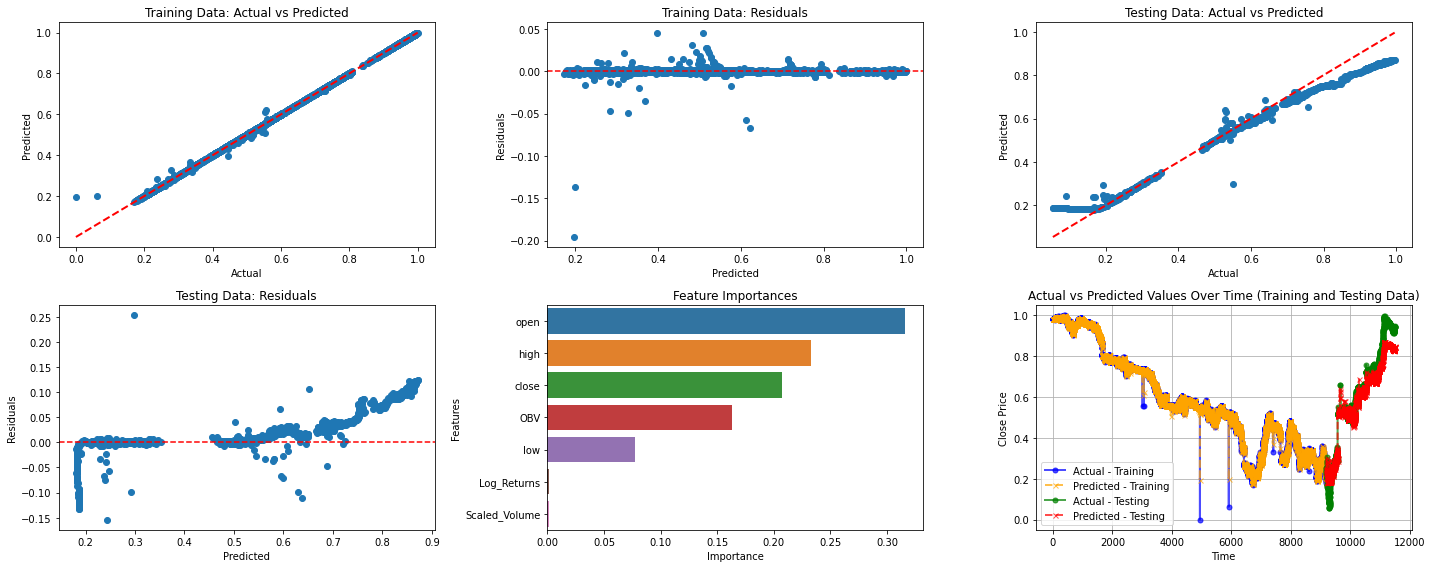

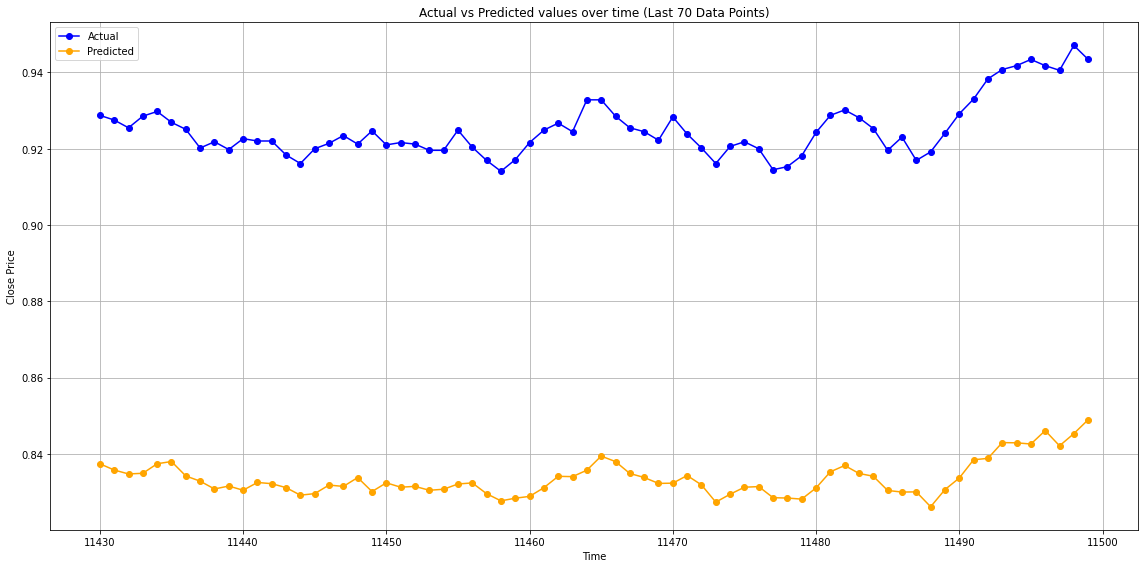

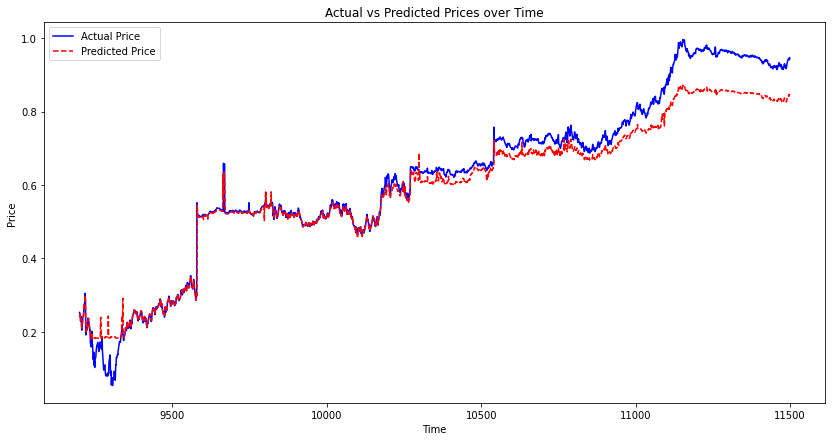

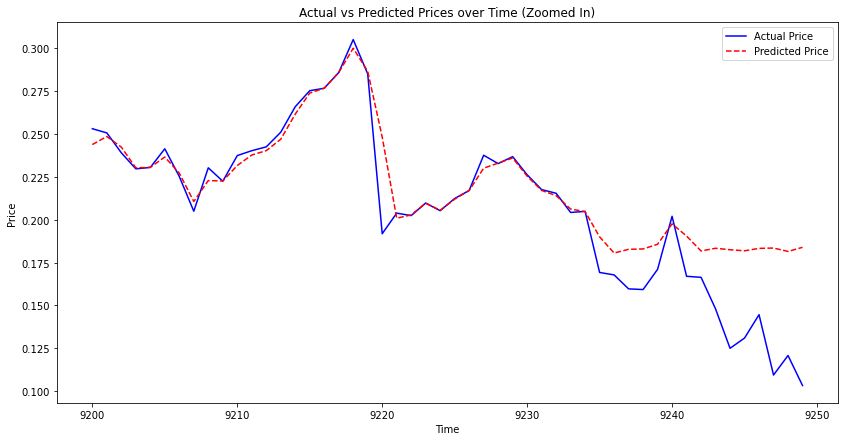

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))

# Calculate OBV (On-Balance Volume)
data['OBV'] = np.where(data['close'] > data['close'].shift(1), data['volume'], 
                       np.where(data['close'] < data['close'].shift(1), -data['volume'], 0)).cumsum()

# Scaling features including OBV and closing price
scaler = MinMaxScaler()
data[['Scaled_Volume', 'OBV', 'close']] = scaler.fit_transform(data[['volume', 'OBV', 'close']])

# Drop NaN values resulting from shifting operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', 'OBV']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and display metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Training R2: {train_r2}")

# Calculate and display metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Testing RMSE: {test_rmse}")
print(f"Testing MAE: {test_mae}")
print(f"Testing R2: {test_r2}")

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


OBV might not be suitable for high-frequency minute data. OBV is typically more effective in longer time frames where volume trends are more pronounced. In high-frequency trading, where data is more granular, volume-based indicators might not capture the necessary nuances as effectively.

CCI

       Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²   Test R²
0  CCI Model    0.177211   0.875298   0.028566  0.274277  0.999758  0.993918


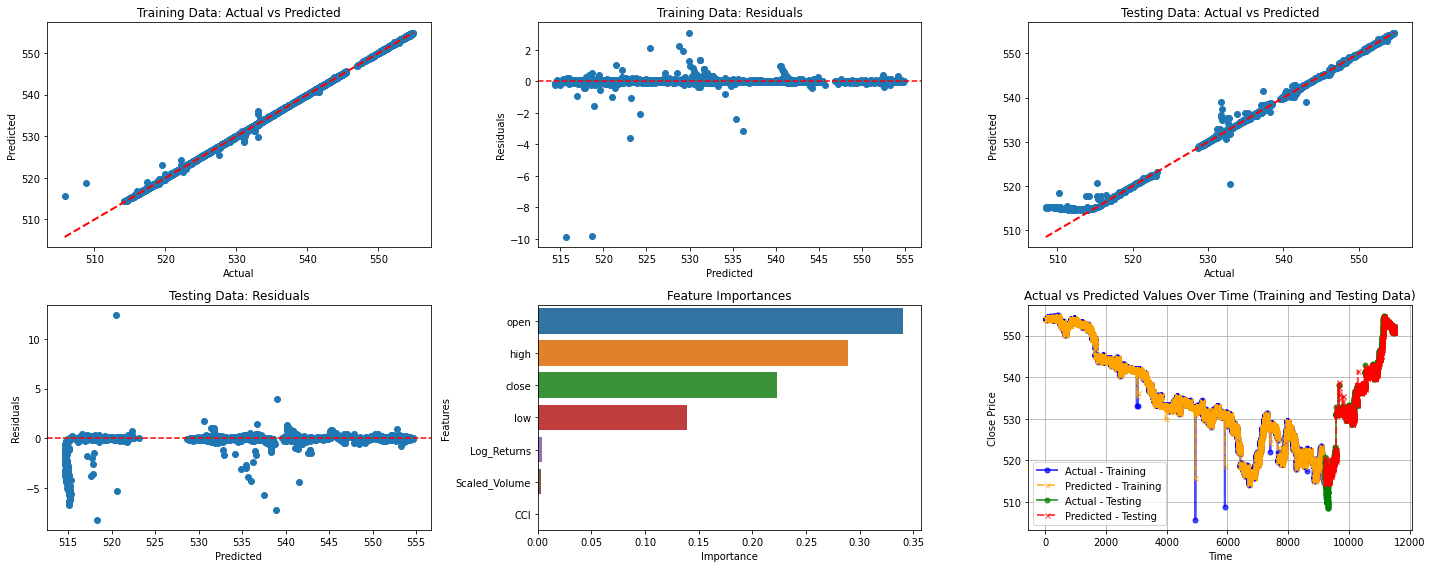

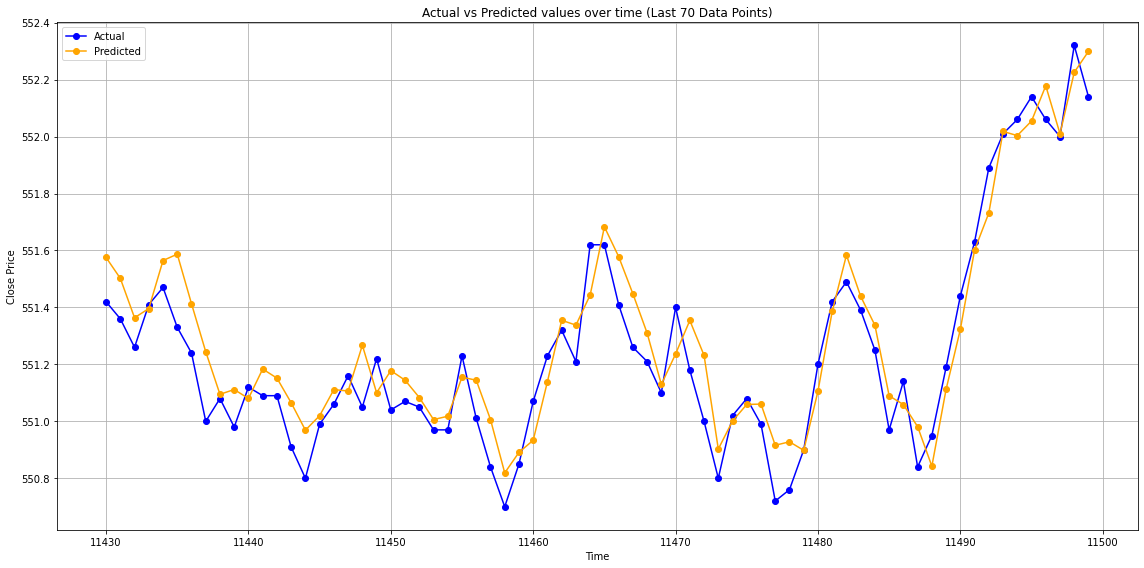

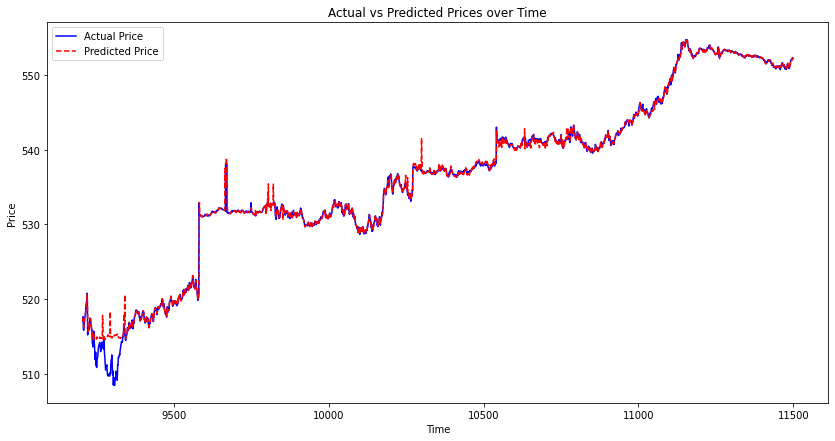

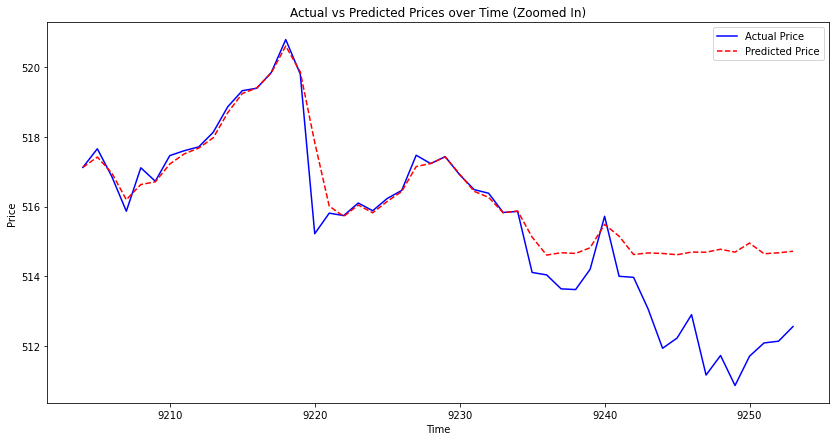

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Calculate the Commodity Channel Index (CCI)
data['Typical_Price'] = (data['high'] + data['low'] + data['close']) / 3
data['SMA_Typical_Price'] = data['Typical_Price'].rolling(window=20).mean()
data['Mean_Deviation'] = data['Typical_Price'].rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Calculate CCI
data['CCI'] = (data['Typical_Price'] - data['SMA_Typical_Price']) / (0.015 * data['Mean_Deviation'])

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume', 'CCI']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and display metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and display metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Store the results for analysis
results = {
    'Model': ['CCI Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('cci_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


Ichimoku cloud indicator 


            Model  Train RMSE  Test RMSE  Train MAE  Test MAE  Train R²  \
0  Ichimoku Model    0.172015   0.886968   0.028283  0.317375  0.999769   

    Test R²  
0  0.993742  


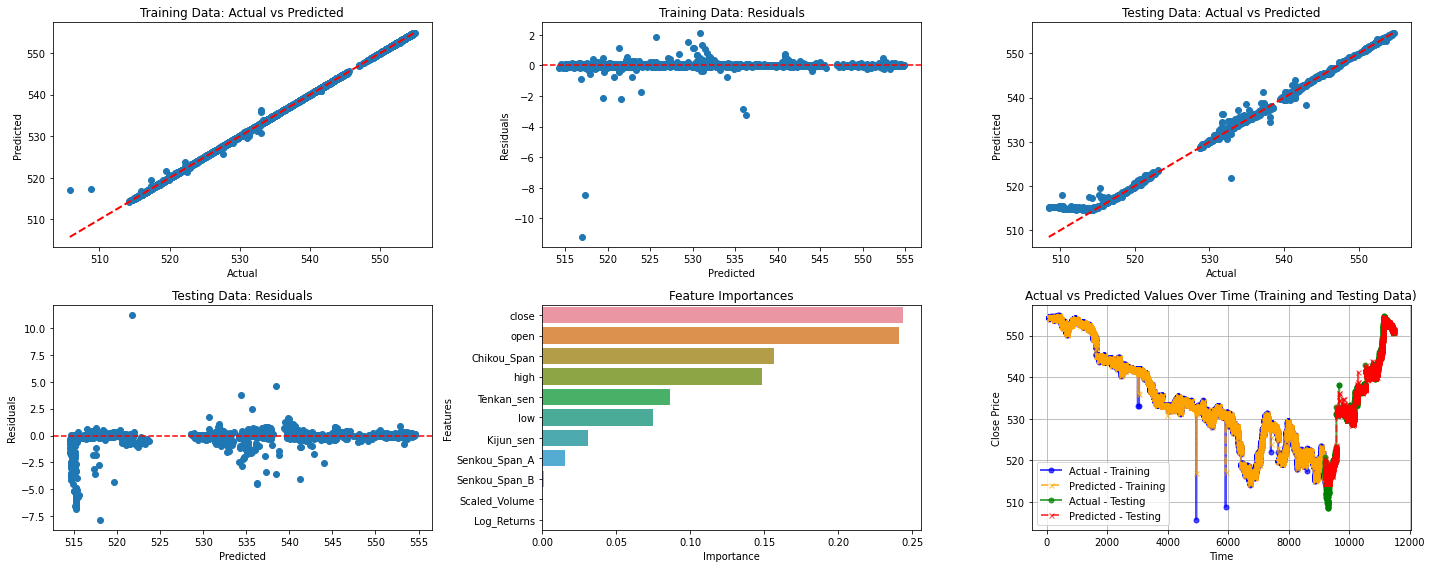

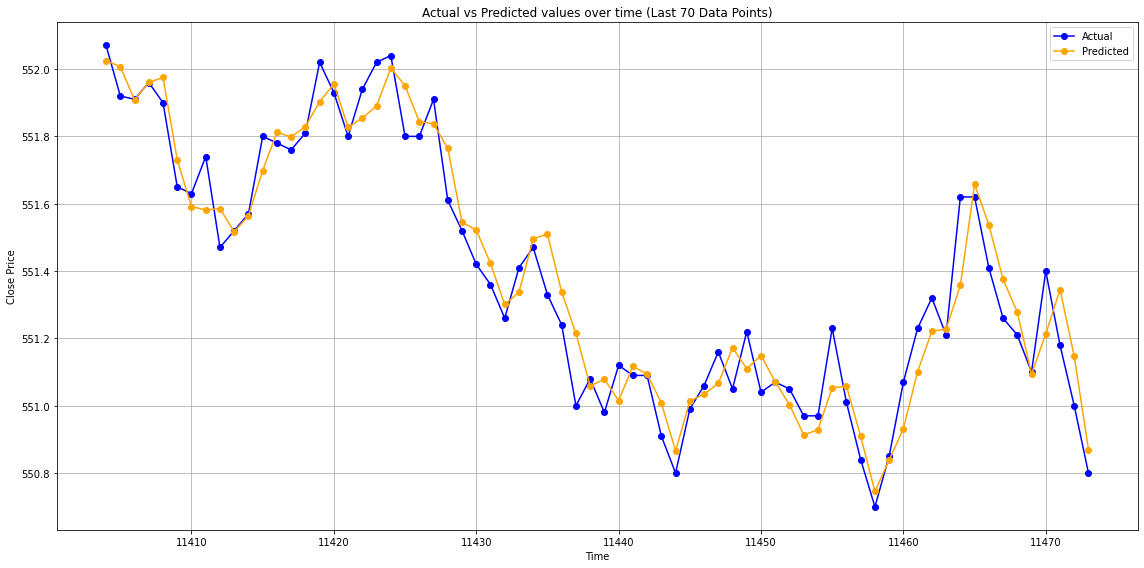

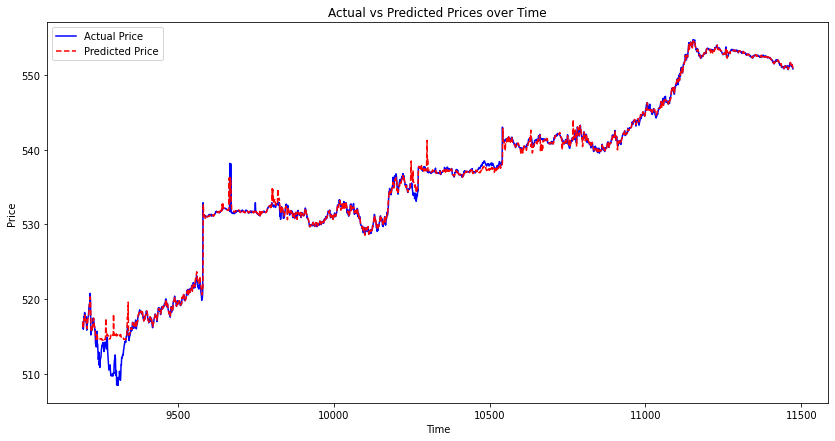

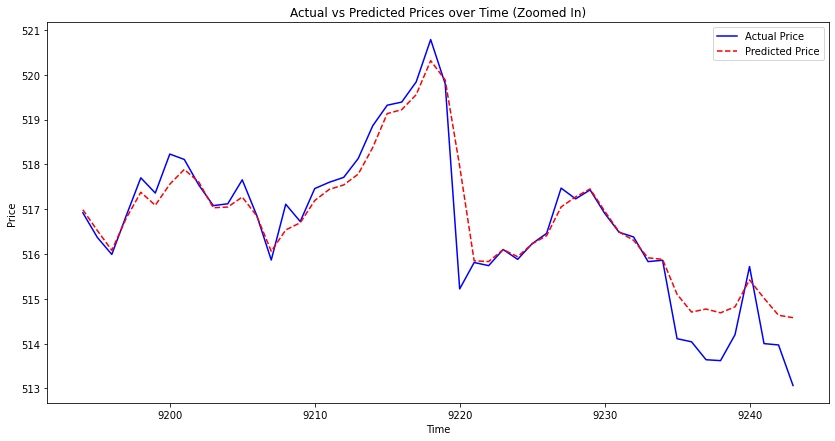

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('SPY_2024-08.csv')

# Feature Engineering
data['Log_Returns'] = np.log(data['close'] / data['close'].shift(1))
data['Scaled_Volume'] = MinMaxScaler().fit_transform(data[['volume']])

# Calculate Ichimoku Cloud components
high_9 = data['high'].rolling(window=9).max()
low_9 = data['low'].rolling(window=9).min()
high_26 = data['high'].rolling(window=26).max()
low_26 = data['low'].rolling(window=26).min()
high_52 = data['high'].rolling(window=52).max()
low_52 = data['low'].rolling(window=52).min()

data['Tenkan_sen'] = (high_9 + low_9) / 2  # Conversion Line
data['Kijun_sen'] = (high_26 + low_26) / 2  # Base Line
data['Senkou_Span_A'] = ((data['Tenkan_sen'] + data['Kijun_sen']) / 2).shift(26)  # Leading Span A
data['Senkou_Span_B'] = ((high_52 + low_52) / 2).shift(26)  # Leading Span B
data['Chikou_Span'] = data['close'].shift(-26)  # Lagging Span

# Drop NaN values resulting from rolling operations
data.dropna(inplace=True)

# Define the features and target variable
X = data[['open', 'high', 'low', 'close', 'Log_Returns', 'Scaled_Volume',
          'Tenkan_sen', 'Kijun_sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Chikou_Span']]
y = data['close'].shift(-1).dropna()
X = X[:-1]  # Align features with the target

# Ensure X and y have the same length
y = y[:len(X)]

# Split the dataset into training and testing sets based on time (not randomly)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize the RandomForestRegressor with the best parameters
rf = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate and display metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate and display metrics for testing data
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Store the results for analysis
results = {
    'Model': ['Ichimoku Model'],
    'Train RMSE': [train_rmse],
    'Test RMSE': [test_rmse],
    'Train MAE': [train_mae],
    'Test MAE': [test_mae],
    'Train R²': [train_r2],
    'Test R²': [test_r2]
}

results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv('ichimoku_model_performance_metrics.csv', index=False)

# Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
feature_importances = pd.DataFrame(importances, index=feature_names, columns=['Importance']).sort_values('Importance', ascending=False)

# Plotting the results with a wider figure
plt.figure(figsize=(20, 8))  # Increase the width to 20

# Plot 1: Predicted vs Actual for Training data
plt.subplot(2, 3, 1)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data: Actual vs Predicted')

# Plot 2: Residuals for Training data
plt.subplot(2, 3, 2)
plt.scatter(y_train_pred, y_train - y_train_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Data: Residuals')

# Plot 3: Predicted vs Actual for Testing data
plt.subplot(2, 3, 3)
plt.scatter(y_test, y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Testing Data: Actual vs Predicted')

# Plot 4: Residuals for Testing data
plt.subplot(2, 3, 4)
plt.scatter(y_test_pred, y_test - y_test_pred)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Data: Residuals')

# Plot 5: Feature Importances
plt.subplot(2, 3, 5)
sns.barplot(x=feature_importances['Importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')

# Plotting the actual vs predicted values for training and testing data
plt.subplot(2, 3, 6)

# Plot for training data
plt.plot(y_train.index, y_train, label='Actual - Training', color='blue', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_train.index, y_train_pred, label='Predicted - Training', color='orange', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

# Plot for testing data
plt.plot(y_test.index, y_test, label='Actual - Testing', color='green', marker='o', markersize=5, linestyle='-', linewidth=2, alpha=0.7)
plt.plot(y_test.index, y_test_pred, label='Predicted - Testing', color='red', marker='x', markersize=5, linestyle='--', linewidth=2, alpha=0.7)

plt.title('Actual vs Predicted Values Over Time (Training and Testing Data)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting the actual vs predicted values over time for the last 70 data points
plt.figure(figsize=(16, 8))

# Select the last 70 data points
time_series = data.index[-70:]  # Assuming the index represents the time series
y_test_actual_last70 = y_test[-70:]
y_test_pred_last70 = y_test_pred[-70:]

plt.plot(time_series, y_test_actual_last70, label='Actual', color='blue', marker='o')
plt.plot(time_series, y_test_pred_last70, label='Predicted', color='orange', marker='o')

plt.title('Actual vs Predicted values over time (Last 70 Data Points)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Actual vs Predicted Prices over Time Plot
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):], y_test_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time')
plt.legend()
plt.show()

# Select a specific time window, e.g., the first 50 data points
time_window = 50
plt.figure(figsize=(14, 7))
plt.plot(data.index[-len(y_test):][:time_window], y_test.iloc[:time_window], label='Actual Price', color='blue')
plt.plot(data.index[-len(y_test):][:time_window], y_test_pred[:time_window], label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices over Time (Zoomed In)')
plt.legend()
plt.show()


Statistical Analysis - Compare all RFR Models, Cross validation and Statistical Testing for all 10 RFR models

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

# Assuming you have the data in a DataFrame `df` as provided earlier
# You can load your data from a CSV file if necessary
df = pd.read_csv('Combined_Model_Performance_Data.csv')

# Extracting the base model metrics
base_train_rmse = df.loc[df['Model'] == 'Base Model', 'Train RMSE'].values[0]
base_test_rmse = df.loc[df['Model'] == 'Base Model', 'Test RMSE'].values[0]
base_train_mae = df.loc[df['Model'] == 'Base Model', 'Train MAE'].values[0]
base_test_mae = df.loc[df['Model'] == 'Base Model', 'Test MAE'].values[0]
base_train_r2 = df.loc[df['Model'] == 'Base Model', 'Train R²'].values[0]
base_test_r2 = df.loc[df['Model'] == 'Base Model', 'Test R²'].values[0]

# Initialize lists to store the results
results = []

# Loop through each model and perform t-tests against the base model
for index, row in df.iterrows():
    if row['Model'] != 'Base Model':
        model_name = row['Model']

        # Paired t-tests
        train_rmse_t, train_rmse_p = ttest_rel([base_train_rmse], [row['Train RMSE']])
        test_rmse_t, test_rmse_p = ttest_rel([base_test_rmse], [row['Test RMSE']])

        train_mae_t, train_mae_p = ttest_rel([base_train_mae], [row['Train MAE']])
        test_mae_t, test_mae_p = ttest_rel([base_test_mae], [row['Test MAE']])

        train_r2_t, train_r2_p = ttest_rel([base_train_r2], [row['Train R²']])
        test_r2_t, test_r2_p = ttest_rel([base_test_r2], [row['Test R²']])

        # Store the results
        results.append({
            'Model': model_name,
            'Train RMSE p-value': train_rmse_p,
            'Test RMSE p-value': test_rmse_p,
            'Train MAE p-value': train_mae_p,
            'Test MAE p-value': test_mae_p,
            'Train R² p-value': train_r2_p,
            'Test R² p-value': test_r2_p
        })

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results)

# Save results to a CSV file or print them
results_df.to_csv('statistical_testing_results.csv', index=False)
print(results_df)
